In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple
from numpy import array, inf, load
import numpy as np
from quantecon import cartesian
import glob


SimplexResult = namedtuple(
    'SimplexResult', ['x', 'lambd', 'fun', 'success', 'status', 'num_iter']
)


filename_res = 'results.csv'
filename_runtimes = 'exec_time.csv'

df_res = pd.read_csv(filename_res, index_col=0)
df_runtime = pd.read_csv(filename_runtimes, index_col=0)

In [2]:
filename_res_comp = 'results_complement.csv'
filename_runtimes_comp = 'exec_time_complement.csv'

df_res_comp = pd.read_csv(filename_res_comp, index_col=0)
df_runtime_comp = pd.read_csv(filename_runtimes_comp, index_col=0)

In [3]:
df_res = df_res_comp.append(df_res, ignore_index=True)
df_runtime = df_runtime_comp.append(df_runtime, ignore_index=True)

## Results analysis

In [4]:
df_res_tuple = df_res.applymap(lambda x: eval(x))

In [5]:
df_res_success = df_res_tuple.applymap(lambda x: int(x.success))

Text(0.5, 0, 'Problem index')

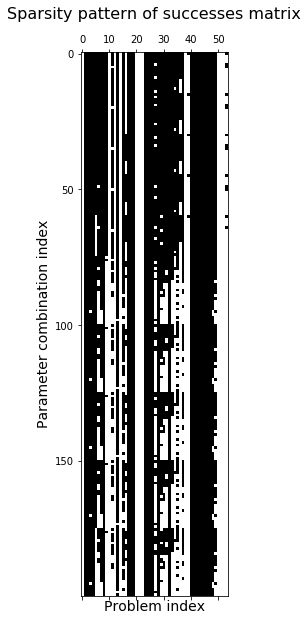

In [6]:
plt.figure(figsize=(10, 10))
plt.spy(df_res_success.values, aspect=None);
plt.title('Sparsity pattern of successes matrix', fontsize=16);
plt.ylabel('Parameter combination index', fontsize=14)
plt.xlabel('Problem index', fontsize=14)

Note: Parameter combinations are generated using: 

```python
fea_tol_list = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
tol_piv_list = [1e-8, 1e-9, 1e-10, 1e-11, 1e-12]
tol_ratio_diff_list = [1e-11, 1e-12, 1e-13, 1e-14, 1e-15]

param_set = cartesian((fea_tol_list, tol_piv_list, tol_ratio_diff_list))
```

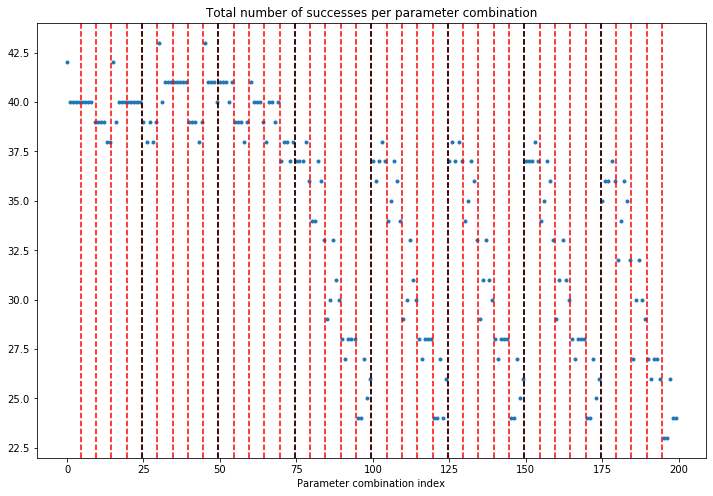

In [7]:
plt.figure(figsize=(12, 8))
plt.plot(df_res_success.sum(axis=1), 'o', markersize=3.);
plt.xlabel('Parameter combination index');
plt.title('Total number of successes per parameter combination');

for x_val in np.arange(4, df_res.shape[0] - 5, 5) + 0.5: 
    plt.axvline(x_val, ls='--', color='red')
    
for x_val in np.arange(24, df_res.shape[0] - 25, 25) + 0.5: 
    plt.axvline(x_val, ls='--', color='black')

In [8]:
# Set of maximizers
argmax_set = df_res_success[df_res_success.sum(axis=1) == df_res_success.sum(axis=1).max()].index
argmax_set

Int64Index([30, 45], dtype='int64')

## Observations

- There are multiple maximimzers.
- Some parameter combinations seem to perform much better than others

In [9]:
df_res_fun = df_res_tuple.applymap(lambda x: x.fun)

In [10]:
# path
data_dir = './linprog_benchmark_files/'

# full_problem_list
problem_list = glob.glob(data_dir + '*.npz')
problem_list.sort()
remove_list = ['80BAU3B', 'BORE3D', 'CAPRI', 'CYCLE', 'CZPROB', 'D6CUBE',
               'DFL001', 'ETAMACRO', 'FINNIS', 'FIT1D', 'FIT1P', 'FIT2D',
               'FIT2P', 'GANGES', 'GFRD-PNC', 'GREENBEA', 'GREENBEB',
               'GROW15', 'GROW22', 'GROW7', 'KB2', 'MAROS', 'MODSZK1',
               'PEROLD', 'PILOT', 'PILOT-JA', 'PILOT-WE', 'PILOT4',
               'PILOT87', 'PILOTNOV', 'RECIPE', 'SHELL', 'SIERRA',
               'STAIR', 'STANDATA', 'STANDMPS', 'TUFF', 'VTP-BASE'
               ]
for name in remove_list:
    problem_list.remove(data_dir + name + '.npz')

    
problems = [load(problem) for problem in problem_list]
funs = array([-problem['obj'] for problem in problems])

In [11]:
TOL = 1e-1

abs_diff = np.abs(df_res_fun - funs)
rel_diff =  np.abs(df_res_fun / funs) - 1

In [12]:
df_res_success_alt = (abs_diff < TOL) | (rel_diff < TOL)

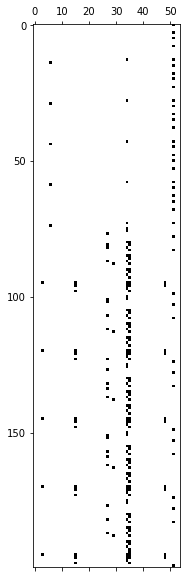

In [13]:
plt.figure(figsize=(10, 10))
plt.spy(np.abs(df_res_success - df_res_success_alt))

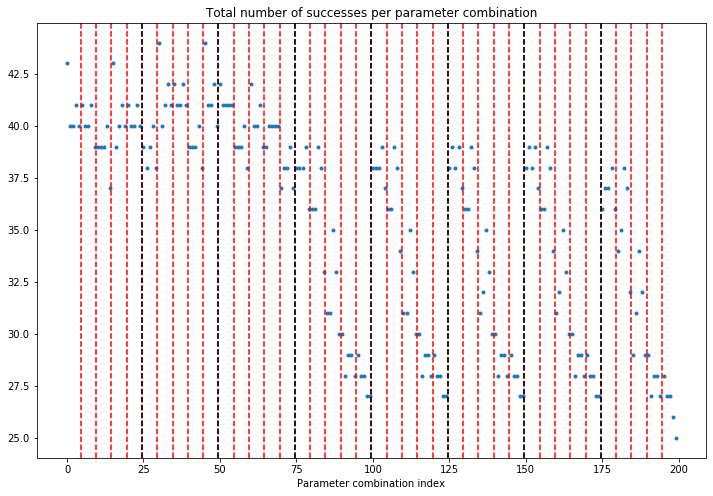

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(df_res_success_alt.sum(axis=1), 'o', markersize=3.);
plt.xlabel('Parameter combination index');
plt.title('Total number of successes per parameter combination')

for x_val in np.arange(4, df_res.shape[0] - 5, 5) + 0.5: 
    plt.axvline(x_val, ls='--', color='red')
    
for x_val in np.arange(24, df_res.shape[0] - 25, 25) + 0.5: 
    plt.axvline(x_val, ls='--', color='black')

In [15]:
# Set of maximizers
argmax_set_alt = df_res_success[df_res_success_alt.sum(axis=1) == df_res_success_alt.sum(axis=1).max()].index
argmax_set_alt

Int64Index([30, 45], dtype='int64')

In [16]:
# Check if argmax_set is a subset of argmax_set_alt
np.all([val in argmax_set_alt for val in argmax_set])

True

## Maximum Number of Iterations Reached

In [58]:
max_itr = 10_000

df_max_itr_reached = df_res_tuple.applymap(lambda x: x.num_iter == max_itr)
df_failure_not_max_itr = (1 - df_res_success).astype(bool) & (1 - df_max_itr_reached)

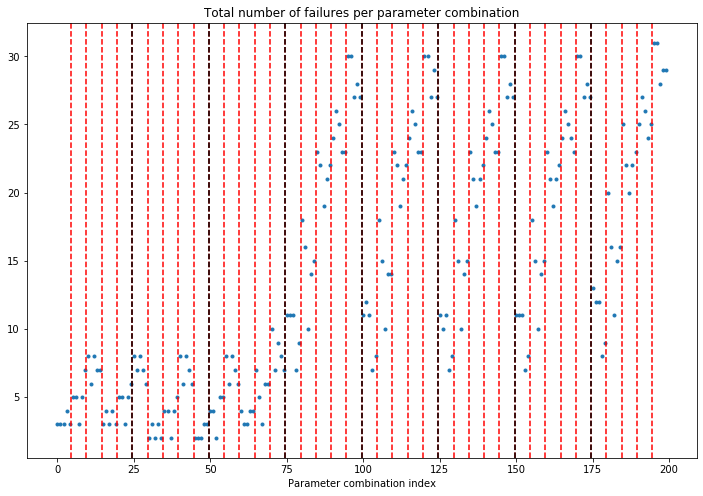

In [59]:
plt.figure(figsize=(12, 8))
plt.plot(df_failure_not_max_itr.sum(axis=1), 'o', markersize=3.);
plt.xlabel('Parameter combination index');
plt.title('Total number of failures per parameter combination')

for x_val in np.arange(4, df_res.shape[0] - 5, 5) + 0.5: 
    plt.axvline(x_val, ls='--', color='red')
    
for x_val in np.arange(24, df_res.shape[0] - 25, 25) + 0.5: 
    plt.axvline(x_val, ls='--', color='black')

In [60]:
# Set of minimizers
argmin_set = df_failure_not_max_itr[df_failure_not_max_itr.sum(axis=1) == df_failure_not_max_itr.sum(axis=1).min()].index
argmin_set

Int64Index([30, 32, 34, 37, 45, 46, 47, 52], dtype='int64')

## Runtime Analysis

In [17]:
# Average runtime across parameters in seconds
df_runtime.mean(axis=0)

0       7.242482
1       0.000643
2       0.000266
3       0.012853
4       0.006833
5       0.009412
6       0.058942
7       0.002455
8       0.000805
9       1.450143
10     43.375180
11      0.008800
12     43.229372
13      0.289360
14     37.780992
15      0.016880
16      0.128997
17      0.018101
18      0.002385
19     56.795238
20    199.911776
21    783.232766
22     10.856205
23      0.001110
24      0.006697
25      0.000336
26      0.000346
27      0.121478
28      0.002173
29      0.040028
30      0.342138
31      1.276337
32      0.009047
33      0.152002
34      0.006325
35      0.028113
36      0.311832
37      0.025422
38      5.554391
39      6.202225
40      0.003838
41      0.001101
42      0.011233
43      0.006752
44      0.045299
45      0.026051
46      0.108743
47      0.056021
48      0.001940
49     13.125219
50    354.733801
51     42.737469
52      0.197467
53      4.513150
dtype: float64

In [18]:
# Runtime standard deviation across parameters in seconds
df_runtime.std(axis=0)

0       7.003023
1       0.000153
2       0.000133
3       0.000840
4       0.000271
5       0.000902
6       0.095976
7       0.000576
8       0.000091
9       1.488942
10     28.031598
11      0.005590
12     43.800949
13      0.045108
14      9.483559
15      0.003993
16      0.075970
17      0.000509
18      0.000134
19      0.317620
20    154.495634
21    556.145025
22      8.546090
23      0.000087
24      0.000559
25      0.000077
26      0.000076
27      0.047167
28      0.000134
29      0.092050
30      0.710465
31      0.873883
32      0.000306
33      0.288164
34      0.010238
35      0.012990
36      0.383553
37      0.012138
38     10.416315
39     14.304036
40      0.000169
41      0.000092
42      0.000541
43      0.000411
44      0.002063
45      0.001083
46      0.003362
47      0.001397
48      0.000125
49      8.542232
50     39.006993
51     24.718894
52      0.466404
53     12.793035
dtype: float64

## Observations

- Problem 20 and 21 have large standard deviations in terms of runtime across parameter combinations
- Problem 20, 21 and 50 take a long time to solve on average

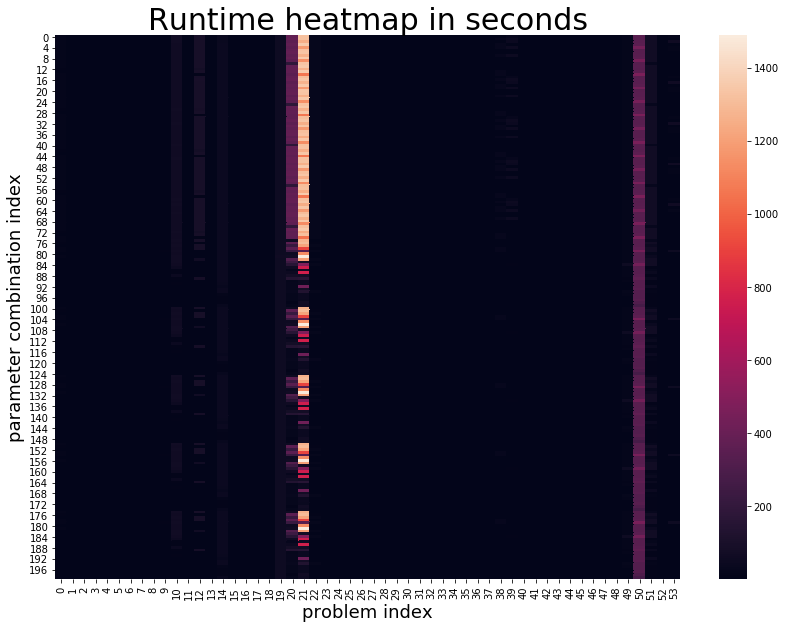

In [19]:
plt.figure(figsize=(14, 10))
sns.heatmap(df_runtime)
plt.title('Runtime heatmap in seconds', fontsize=30)
plt.xlabel('problem index', fontsize=18);
plt.ylabel('parameter combination index', fontsize=18);

In [20]:
df_runtime.iloc[argmax_set_alt].mean(axis=1)

30    45.018283
45    45.501234
dtype: float64

In [21]:
fea_tol_list = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
tol_piv_list = [1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12]
tol_ratio_diff_list = [1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]

param_set = cartesian((fea_tol_list, tol_piv_list, tol_ratio_diff_list))

In [22]:
fea_tol_list = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
tol_piv_list = [1e-5, 1e-6, 1e-7]
tol_ratio_diff_list = [1e-11, 1e-12, 1e-13, 1e-14, 1e-15]

param_set_comp = cartesian((fea_tol_list, tol_piv_list, tol_ratio_diff_list))

In [23]:
param_set = np.block([[param_set_comp], [param_set]])

In [24]:
# Minimize average runtime conditional on maximizing total number of success
param_set[df_runtime.loc[argmax_set_alt].mean(axis=1).idxmin()]

array([1.e-06, 1.e-05, 1.e-11])